In [1]:
import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm


import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from src import DATA_PATH, ROOT_PATH
VERSION = 'v6'


# 前処理

In [2]:
food_values = pd.read_csv(os.path.join(DATA_PATH, "food_value.csv"))
resp = pd.read_csv(os.path.join(DATA_PATH, "data_responses_NCNP_2types.csv"))
res_L_mean = resp.groupby("img")["res_L"].mean()
res_H_mean = resp.groupby("img")["res_H"].mean()
res_T_mean = resp.groupby("img")["res_T"].mean()

In [3]:
gram_value_is_not_nan = ~np.isnan(food_values["grams_total"].values)
labels = np.array(
    [
        res_L_mean.values,
        res_H_mean.values,
        res_T_mean.values,
        food_values["kcal_100g"].values,
        food_values["protein_100g"].values,
        food_values["fat_100g"].values,
        food_values["carbs_100g"].values,
        food_values["kcal_total"].values,
        food_values["grams_total"].values,
        food_values["red"].values,
        food_values["green"].values,
        food_values["blue"].values,
        food_values["is_processed_foods"].astype(int).values,
        food_values["is_testy"].astype(int).values,
    ]
)

labels.shape

(14, 896)

# 分析

## Ridge回帰

In [4]:
from src.analysis import (
    pearson_correlation,
    init_ridge_analysis,
    get_features_pc,
    search_best_binary,
    search_best_regression,
)
from src.const import index_name
gc.collect()

# inn is is not nan

search_binary, search_regression = init_ridge_analysis()
data_len = 36
result_dfs = pd.DataFrame(columns=np.arange(data_len))

for type_ in ["obesity", "normal"]:
    result_df = pd.DataFrame(index=index_name, columns=np.arange(data_len))
    result_df["type"] = type_
    save_dir = os.path.join(
        DATA_PATH,
        "output",
        "activation_features_regression",
        VERSION,
        type_,
    )
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    for i in tqdm(range(data_len)):
        data_dir = os.path.join(
            ROOT_PATH,
            "tmp",
            VERSION,
            type_,
            "intermediate_feature",
            f"intermediate_outputs_by_layer_{i + 1}.pth",
        )
        data = torch.load(
            data_dir,
            map_location="cpu",
            weights_only=True,
        )
        activation_features = data.flatten(1).numpy()
        del data

        print(f"Layer {i}")
        print("pca start")
        activation_features_pc = get_features_pc(activation_features, save_dir, i)
        print(activation_features.shape[1], "to", activation_features_pc.shape[1])

        (
            X_train,
            X_test,
            Y_train,
            Y_test,
            inn_train,
            inn_test,
        ) = train_test_split(
            activation_features_pc,
            labels.T,
            gram_value_is_not_nan,
            test_size=0.2,
            shuffle=True,
            random_state=i
        )

        activation_features_pc = None

        print("binary start")
        best_pipe_binary = search_best_binary(
            search_binary, X_train, Y_train[:, -2:], save_dir, i
        )

        auc = best_pipe_binary.score(X_test, Y_test[:, -2:])
        binary_pred = best_pipe_binary.predict(X_test)
        print(auc)
        result_df.iloc[-2:, i] = roc_auc_score(
            Y_test[:, -2:], binary_pred, average=None, multi_class="ovo"
        )
        best_pipe_binary = None
        binary_pred = None
        gc.collect()

        print("regression start")
        index_is_gram = np.array(
            [
                idx in ["grams_total", "protein_100g", "fat_100g", "carbs_100g"]
                for idx in index_name
            ]
        )

        X_train_inn, X_test_inn, Y_train_inn, Y_test_inn = (
            X_train[inn_train, :],
            X_test[inn_test, :],
            Y_train[inn_train, :][:, index_is_gram],
            Y_test[inn_test, :][:, index_is_gram],
        )
        index_is_not_gram = np.logical_not(index_is_gram)
        index_is_not_gram[-2:] = False
        for is_gram_index, (X_train_tmp, X_test_tmp, Y_train_tmp, Y_test_tmp) in enumerate(
            [
                (
                    X_train,
                    X_test,
                    Y_train[:, index_is_not_gram],
                    Y_test[:, index_is_not_gram],
                ),
                (X_train_inn, X_test_inn, Y_train_inn, Y_test_inn),
            ]
        ):
            name = "is_gram_" if is_gram_index else "_"
            best_pipe_regression = search_best_regression(
                search_regression, X_train_tmp, Y_train_tmp, save_dir, name, i
            )
            corr = best_pipe_regression.score(X_test_tmp, Y_test_tmp)
            regression_pred = best_pipe_regression.predict(X_test_tmp)
            print(corr)
            index = index_is_gram if is_gram_index else index_is_not_gram
            result_df.iloc[index, i] = pearson_correlation(
                Y_test_tmp, regression_pred, average="micro"
            )
            best_pipe_regression = None
            regression_pred = None
            gc.collect()
    result_dfs = pd.concat([result_dfs, result_df])

ValueError: too many values to unpack (expected 2)

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from src import DATA_PATH, ROOT_PATH

sns.set_theme(font="BIZ UDPGothic")
sns.set_style("whitegrid")
plt.rcParams["font.family"] = ["BIZ UDPGothic"]

In [2]:
if os.path.join(
        DATA_PATH,
        "output",
        "activation_regression",
        VERSION,
        "pca"):
    os.makedirs(
        os.path.join(
            DATA_PATH,
            "output",
            "activation_regression",
            VERSION,
            "pca"),
        exist_ok=True)
# result_dfs.to_csv(
#     os.path.join(
#         DATA_PATH,
#         "output",
#         "activation_regression",
#         VERSION,
#         "pca",
#         "result_activation_features_regression.csv",
#     )
# )
result_dfs = pd.read_csv(
    os.path.join(
        DATA_PATH,
        "output",
        "activation_regression",
        VERSION,
        "pca",
        "result_activation_features_regression.csv",
    ),
    index_col=0,
)
food_values = pd.read_csv(os.path.join(DATA_PATH, "food_value.csv"))
resp = pd.read_csv(os.path.join(DATA_PATH, "data_responses_NCNP_2types.csv"))
res_L_mean = resp.groupby("img")["res_L"].mean()
res_H_mean = resp.groupby("img")["res_H"].mean()
res_T_mean = resp.groupby("img")["res_T"].mean()


NameError: name 'VERSION' is not defined

In [ ]:
display(result_dfs)

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,type
res_L_mean,0.307156,0.125862,0.178331,0.143771,0.310864,0.332298,0.36788,0.347589,0.484238,0.525554,...,0.917666,0.894892,0.927275,0.930763,0.937071,0.89412,0.893523,0.945836,0.919477,obesity
res_H_mean,0.340568,0.329448,0.485466,0.344846,0.317924,0.602264,0.715349,0.60611,0.669951,0.671409,...,0.738664,0.748063,0.794822,0.752533,0.787959,0.72821,0.712203,0.837327,0.816124,obesity
res_T_mean,0.318518,0.244485,0.305774,0.197493,0.397568,0.410067,0.479198,0.440212,0.552603,0.593025,...,0.910217,0.898798,0.914447,0.923135,0.925193,0.882633,0.891128,0.936171,0.894039,obesity
kcal_100g,0.379297,0.291198,0.395826,0.227264,0.294537,0.480137,0.547065,0.465706,0.538456,0.598781,...,0.620375,0.53755,0.617325,0.656844,0.63975,0.614854,0.544906,0.681433,0.703183,obesity
protein_100g,0.093061,0.372349,0.378578,0.263389,0.359744,0.366661,0.453325,0.506712,0.454588,0.580018,...,0.499806,0.379782,0.574957,0.483366,0.562917,0.488618,0.457636,0.556833,0.519014,obesity
fat_100g,0.070606,0.20649,0.304296,0.096381,0.093822,0.264531,0.507732,0.375672,0.307399,0.391854,...,0.586176,0.372328,0.509668,0.649227,0.540692,0.527531,0.402427,0.558735,0.490015,obesity
carbs_100g,0.2146,0.252394,0.287804,0.292621,0.199541,0.446433,0.535221,0.439646,0.561014,0.529576,...,0.616434,0.514871,0.631155,0.665351,0.677231,0.612019,0.674813,0.757101,0.720938,obesity
kcal_total,-0.010645,0.213026,0.066156,0.225525,0.077402,0.181771,0.250534,0.288667,0.225498,0.170888,...,0.287169,0.474687,0.440037,0.268053,0.227644,0.142223,0.239928,0.352653,0.273082,obesity
grams_total,0.004954,-0.009989,0.107863,-0.000827,-0.036315,0.038134,0.098452,0.182298,-0.011884,0.190236,...,0.178606,0.215482,0.188894,0.062801,0.139806,0.266376,0.129325,0.350947,0.13656,obesity
red,0.40556,0.794224,0.782413,0.512491,0.694908,0.829799,0.89528,0.779693,0.839331,0.840129,...,0.792771,0.701491,0.809458,0.766244,0.757082,0.775815,0.693848,0.783462,0.776522,obesity


## RSA

In [ ]:
def create_label_similarity_matrix(label_values):
    labels_tensor = torch.tensor(label_values)
    num_labels = labels_tensor.size(0)
    similarity_matrix = torch.zeros((num_labels, num_labels))
    # コサイン類似度行列を計算
    for i in range(num_labels):
        for j in range(i + 1):  # iまでループすることで下三角のみを計算
            similarity_matrix[i, j] = torch.abs(
                labels_tensor[i].unsqueeze(0) - labels_tensor[j].unsqueeze(0)
            )
            similarity_matrix[j, i] = similarity_matrix[i, j]
    return similarity_matrix


In [ ]:
L_similarity_matrix = create_label_similarity_matrix(res_L_mean.values)
H_similarity_matrix = create_label_similarity_matrix(res_H_mean.values)
T_similarity_matrix = create_label_similarity_matrix(res_T_mean.values)

kcal_100g_similarity_matrix = create_label_similarity_matrix(
    food_values["kcal_100g"].values
)
protein_100g_similarity_matrix = create_label_similarity_matrix(
    food_values["protein_100g"].values
)
fat_100g_similarity_matrix = create_label_similarity_matrix(
    food_values["fat_100g"].values
)
carbs_100g_similarity_matrix = create_label_similarity_matrix(
    food_values["carbs_100g"].values
)
kcal_similarity_matrix = create_label_similarity_matrix(
    food_values["kcal_total"].values
)
processed_similarity_matrix = create_label_similarity_matrix(
    food_values["is_processed_foods"].values
)
testy_similarity_matrix = create_label_similarity_matrix(food_values["is_testy"].values)
grams_similarity_matrix = create_label_similarity_matrix(
    food_values["grams_total"].values
)
red_similarity_matrix = create_label_similarity_matrix(food_values["red"].values)
green_similarity_matrix = create_label_similarity_matrix(food_values["green"].values)
blue_similarity_matrix = create_label_similarity_matrix(food_values["blue"].values)

# 可視化

## Ridge回帰

In [ ]:
# type =
result_dfs.reset_index().melt(
    id_vars=["index", "type"],
    # value_vars=["type"],

    var_name="Layer",
    value_name="Score"
)
# a[a["index"] == "res_L_mean"]

,index,type,Layer,Score
0,res_L_mean,obesity,0,0.307156
1,res_H_mean,obesity,0,0.340568
2,res_T_mean,obesity,0,0.318518
3,kcal_100g,obesity,0,0.379297
4,protein_100g,obesity,0,0.093061
...,...,...,...,...
1003,red,normal,35,0.762298
1004,green,normal,35,0.766739
1005,blue,normal,35,0.748081
1006,is_processed_foods,normal,35,0.806135


,0,1,2,3,4,5,6,7,8,9,10,11
Score,0.305222,0.175042,0.29683,0.422915,0.583739,0.743646,0.862631,0.876302,0.888138,0.902418,0.910165,0.907928


,1,2,3,4,5,6,7,8,9,10,11,12
Score,0.305222,0.175042,0.29683,0.422915,0.583739,0.743646,0.862631,0.876302,0.888138,0.902418,0.910165,0.907928
attr,主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み)


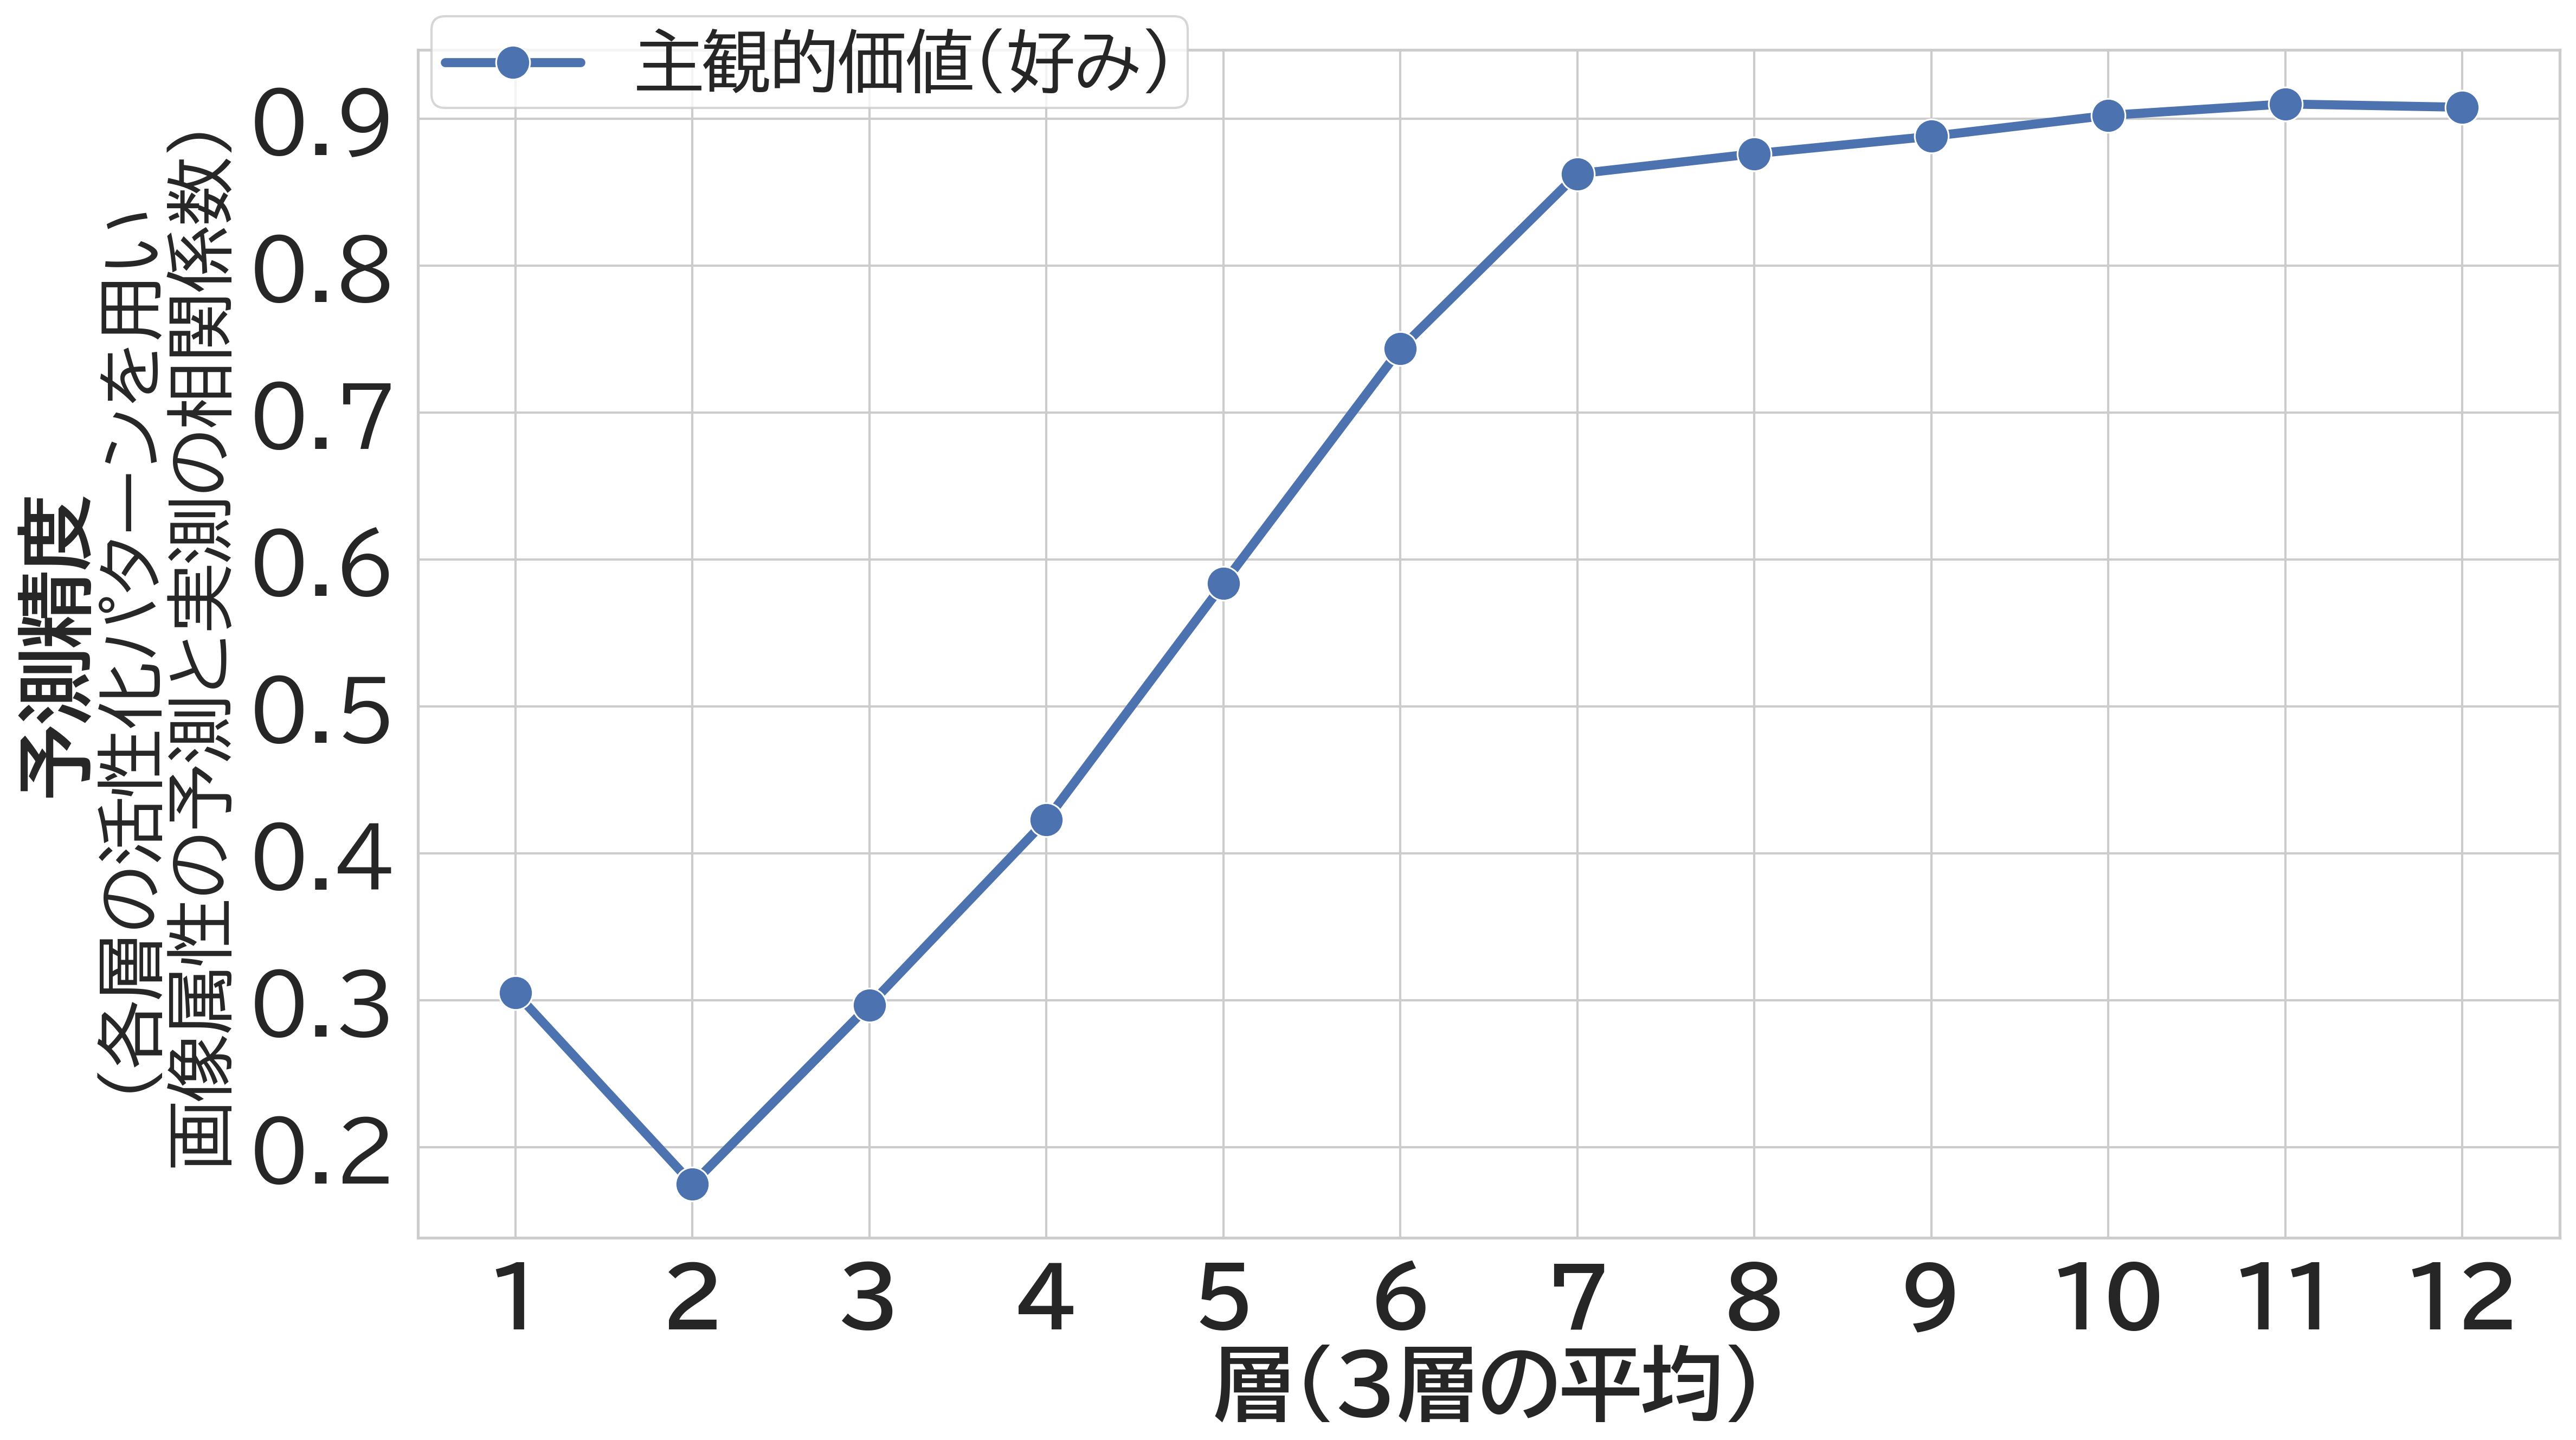

,0,1,2,3,4,5,6,7,8,9,10,11
Score,0.307156,0.149321,0.337014,0.45246,0.700776,0.780847,0.882729,0.898503,0.893702,0.914693,0.917643,0.908238


,1,2,3,4,5,6,7,8,9,10,11,12
Score,0.307156,0.149321,0.337014,0.45246,0.700776,0.780847,0.882729,0.898503,0.893702,0.914693,0.917643,0.908238
attr,主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み),主観的価値(好み)


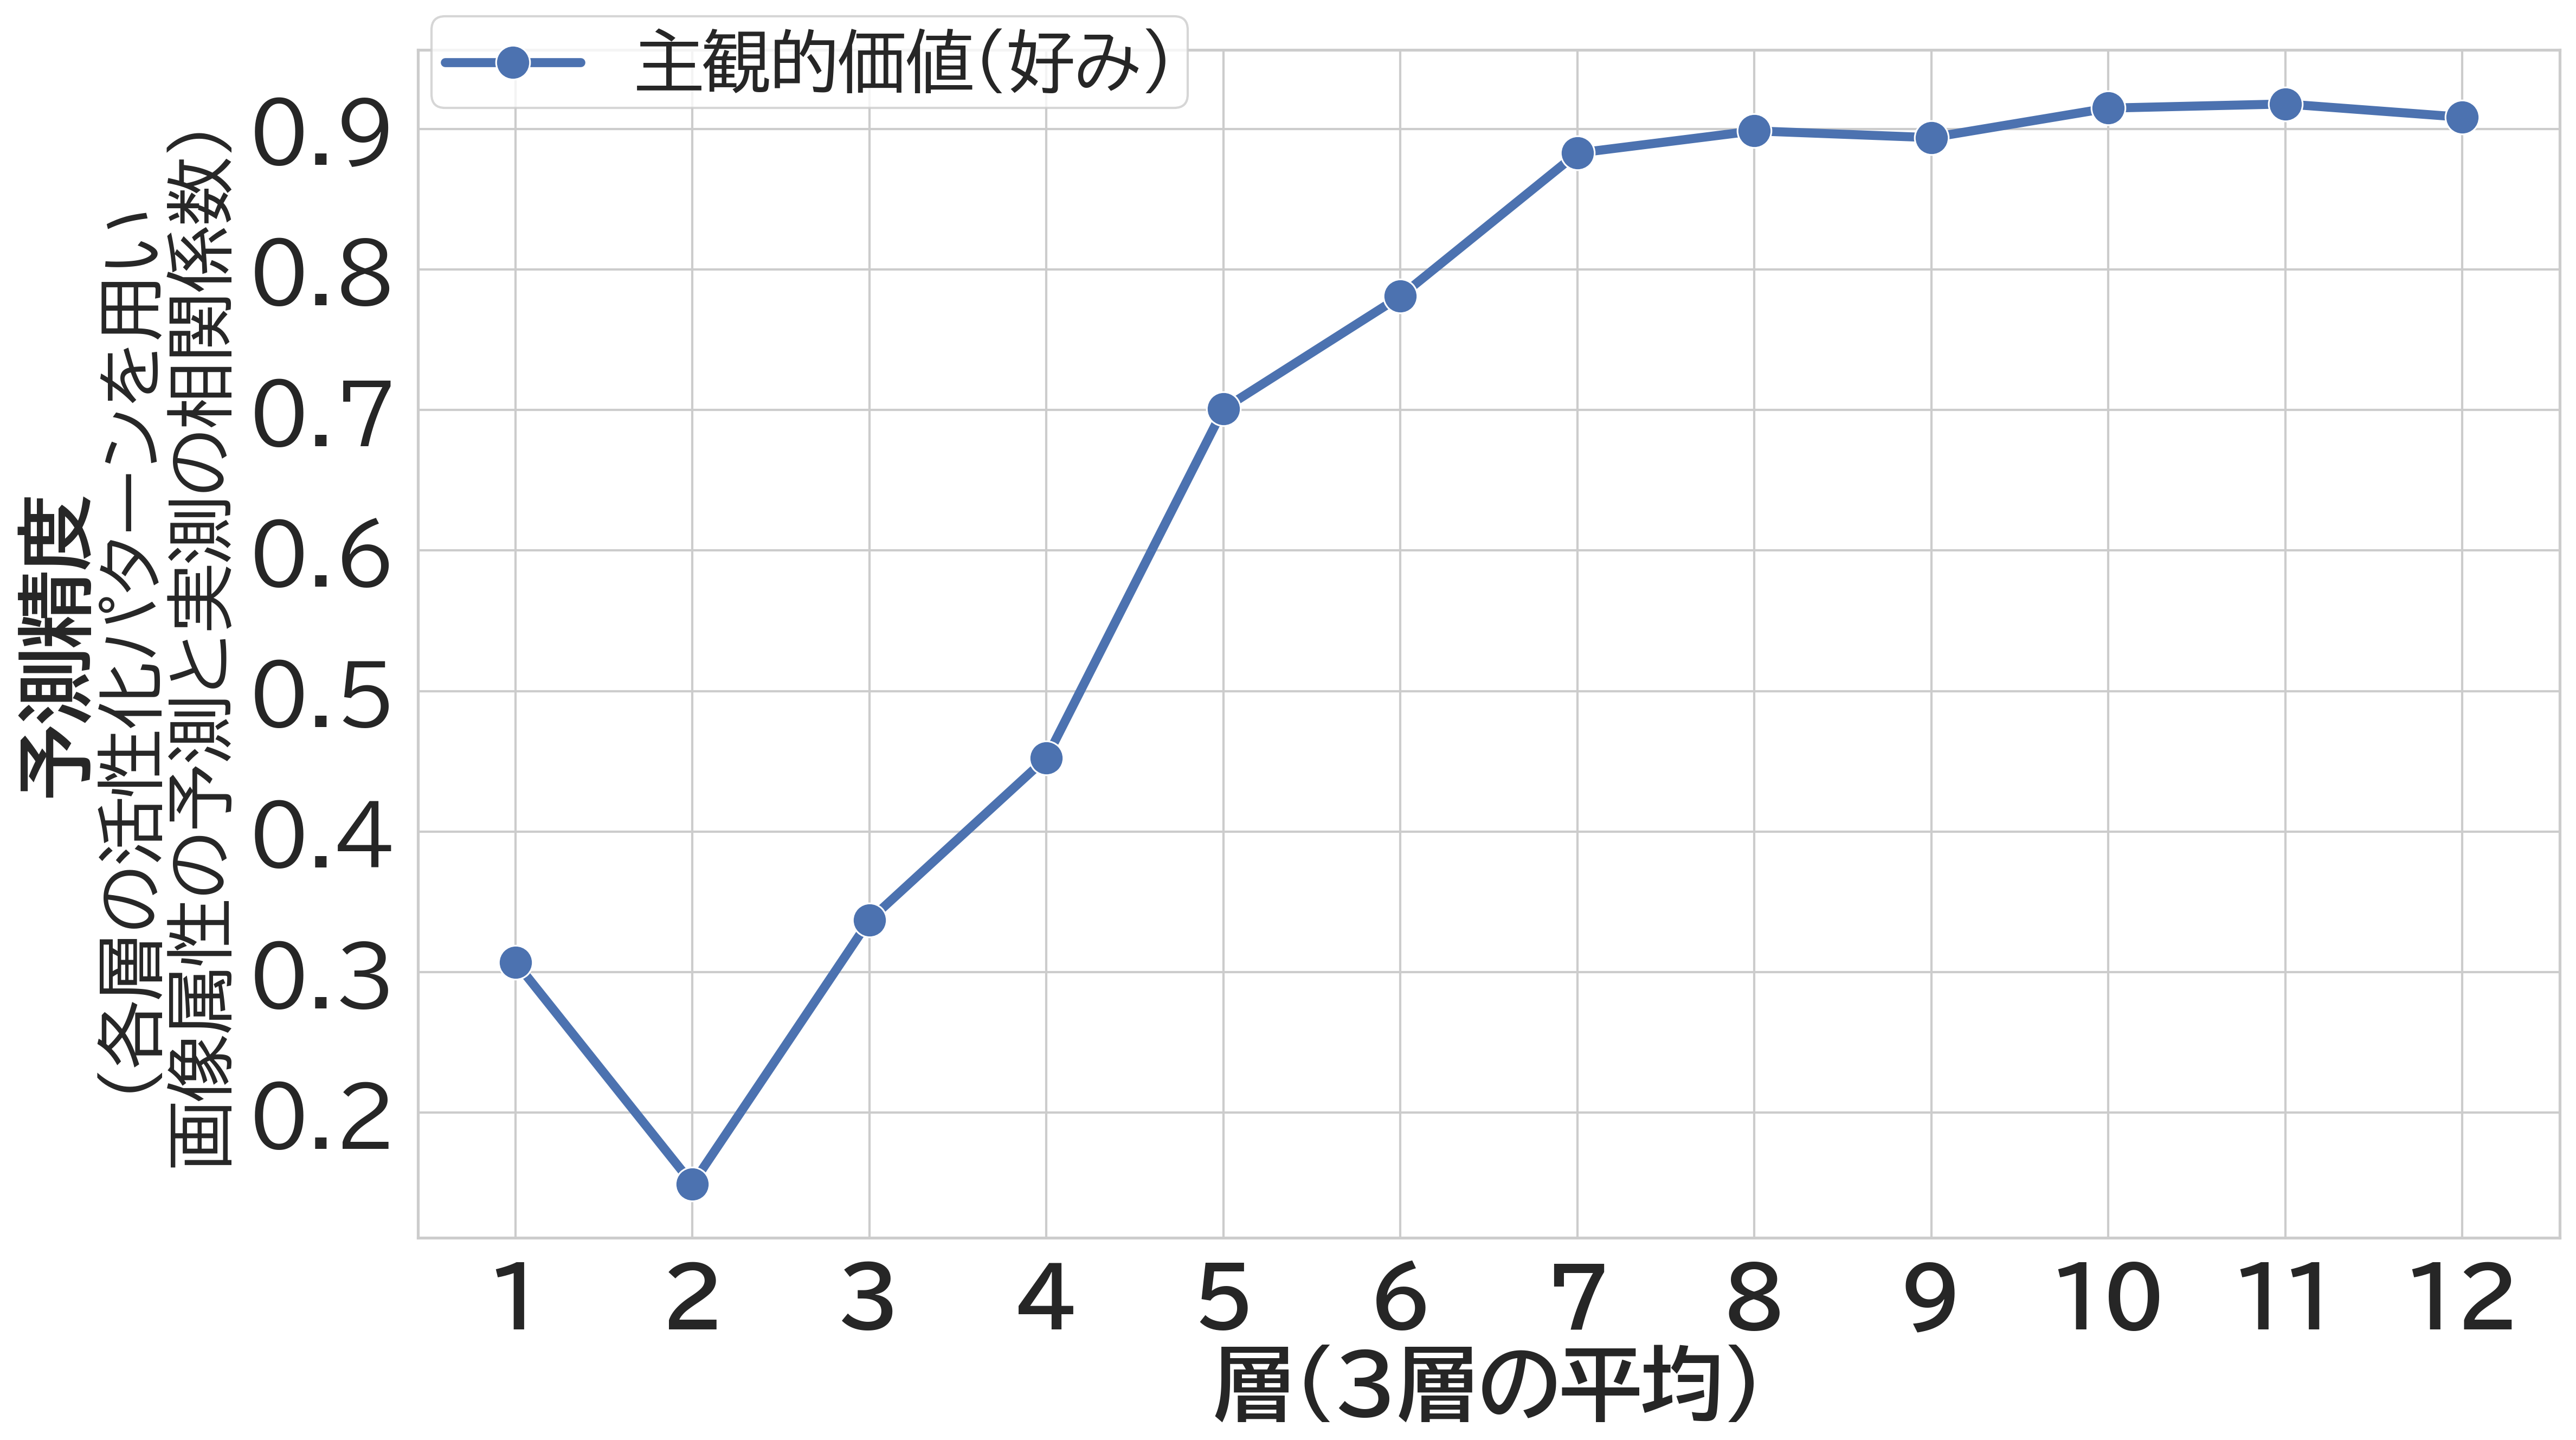

In [ ]:
melt_dfs = (
    result_dfs.reset_index()
    .melt(
        id_vars=["index", "type"],
        # value_vars=["type"],
        var_name="Layer",
        value_name="Score",
    )
    .rename(columns={"index": "attribute"})
)
melt_dfs["Layer"] = melt_dfs["Layer"].astype(str).str.extract(r"(\d+)").astype(int)

for type_, melt_df in melt_dfs.groupby("type"):
    df_list = []
    group_dict = {
        # "主観的価値(好み)": ["res_L_mean"],
        "美味しさ": ["res_T_mean"],
        "健康度" : ["res_H_mean"],
        "色 (RGB)": ["blue", "green", "red"],
        # "カロリー": ["kcal_100g"],
        # "タンパク質": ["protein_100g"],
        # "脂質": ["fat_100g"],
        # "炭水化物": ["carbs_100g"],
        "栄養価": ["kcal_100g", "protein_100g", "fat_100g", "carbs_100g"],
        # "Size": ["kcal_total", "grams_total"],
    }
    for key, attrs in group_dict.items():
        # for attr in attrs:
        #     print(key, attr)
        attr_df = pd.DataFrame(
            melt_df[melt_df["attribute"].isin(attrs)]
            .groupby("Layer")["Score"]
            .mean().sort_index()
            .rolling(window=3, min_periods=1, step=3)
            .mean()
            .dropna()
            .reset_index(drop=True)
        )
        display(attr_df.T)
        attr_df["attr"] = key
        attr_df.index += 1
        df_list.append(attr_df)

    data = pd.concat(df_list)
    display(data.T)
    fig = plt.figure(figsize=(16, 9), dpi=300)
    sns.lineplot(
        data=data.reset_index(),
        x="index",
        y="Score",
        hue="attr",
        style="attr",
        marker="o",
        markersize=15,
        # err_kws={"alpha": 0.15},
        linewidth=4,
    )
    melt_df["Layer"] = melt_df["Layer"].astype("int")
    melt_df["attribute"] = melt_df["attribute"].astype("category")
    melt_df["Score"] = melt_df["Score"].astype(float)
    # sns.lineplot(data=melt_df, x="Layer", y="Score", hue="attribute")
    plt.xlabel("層(３層の平均)", fontsize=36, fontweight="bold")
    plt.ylabel(
        "予測精度", fontsize=34, labelpad=70, fontweight="bold"
    )
    plt.text(
        -0.12,
        0.5,
        "(各層の活性化パターンを用い\n画像属性の予測と実測の相関係数)",
        fontsize=30,
        horizontalalignment="center",
        verticalalignment="center",
        transform=plt.gca().transAxes,
        # rotation=45,
        rotation=90,
    )
    plt.yticks(fontsize=36)
    plt.xticks(range(1, max(data.index.to_series().unique()) + 1), fontsize=36, fontweight="bold")
    plt.legend(
        fontsize=30,
        loc="upper left",
        borderpad=0.2,
        # labelspacing=0.2,
        bbox_to_anchor=(0, 1.04),
        borderaxespad=0.2,
        # horizon
        ncol=2,
        # framealpha=0,
        columnspacing=0.2,
        # fontweight="bold",
    )
    plt.tight_layout()
    plt.show()
    fig.savefig(
        os.path.join(DATA_PATH, "output", "activation_regression", VERSION, "pca",  f"{type_}_result.png"), bbox_inches="tight"
    )

## RSA

In [ ]:
from scipy.stats import t

matrixs = torch.load(
    os.path.join(
        ROOT_PATH, "tmp", VERSION, "normal", "intermediate_feature", "layer_matrixs.pth"
    )
)
corr = np.corrcoef(
    fat_100g_similarity_matrix[gram_value_is_not_nan, :][:, gram_value_is_not_nan].flatten(),
    matrixs[28, gram_value_is_not_nan, :][:, gram_value_is_not_nan].flatten()
)[0, 1]

    # Compute p-value using SciPy
n = len(fat_100g_similarity_matrix[gram_value_is_not_nan, :][:, gram_value_is_not_nan].flatten())
print(n)

t_stat  = abs(corr * np.sqrt((n - 2) / (1 - corr**2)))
df = n - 2
p_value = t.sf(t_stat, df) 
print(corr,t_stat, p_value)

322624
-0.02984853686465144 16.96147385913227 8.443919451978823e-65


/tmp/ipykernel_241053/3304866359.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  matrixs = torch.load(


/tmp/ipykernel_241053/706082051.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  matrixs = torch.load(


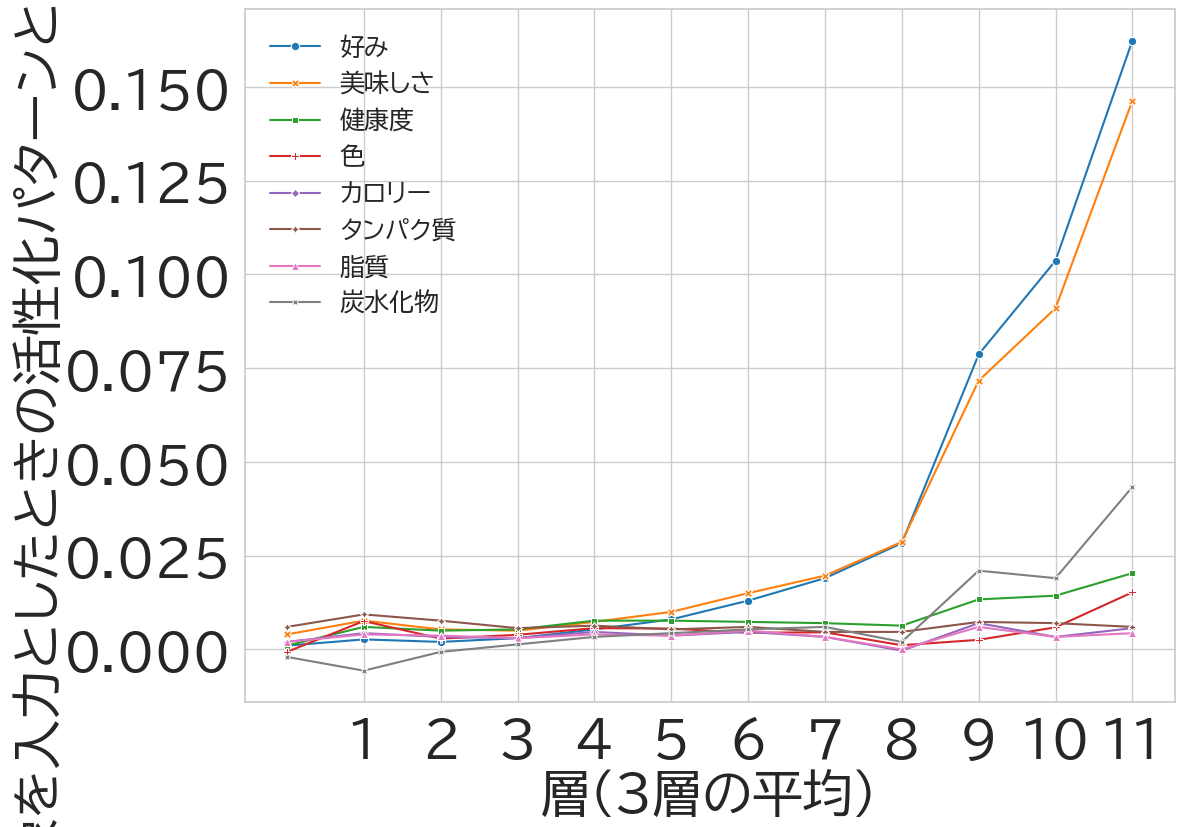

/tmp/ipykernel_241053/706082051.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  matrixs = torch.load(


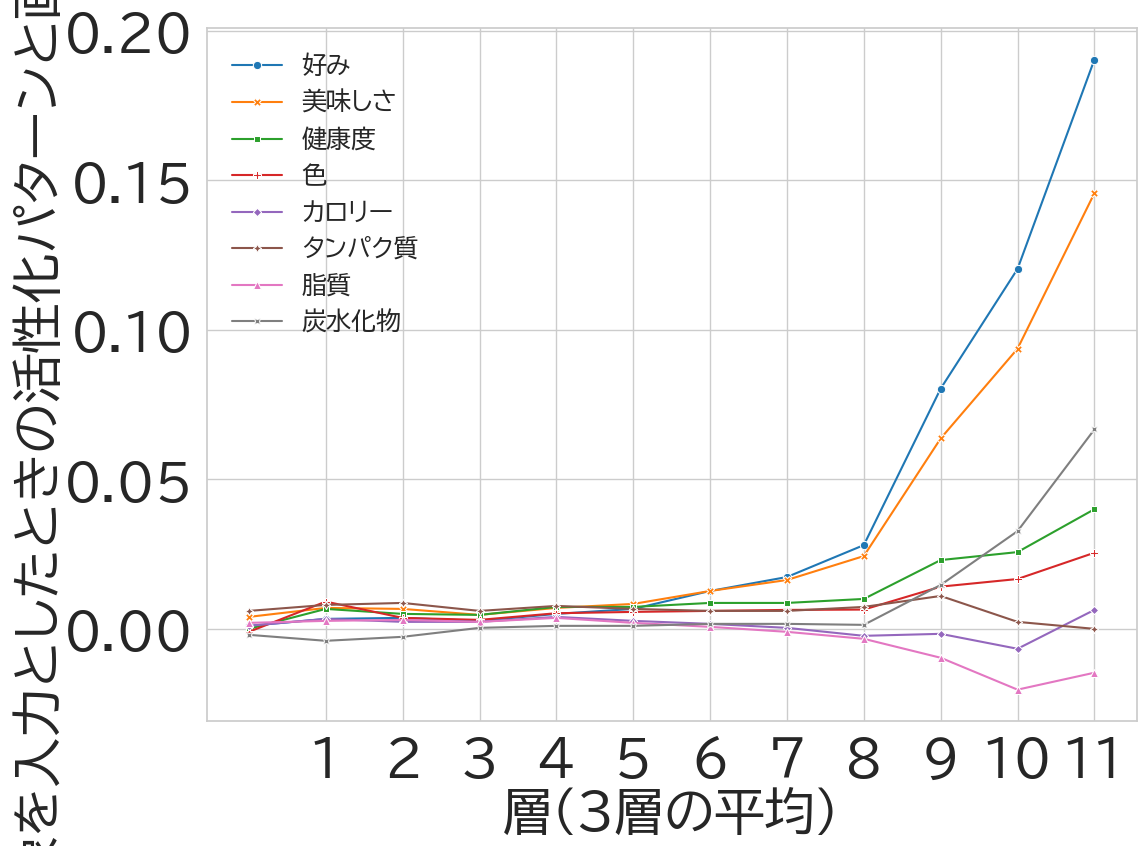

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from src.analysis import calc_matrix_corr

for type_ in ["obesity", "normal"]:
    matrixs = torch.load(
        os.path.join(
            ROOT_PATH, "tmp", VERSION, type_,  "intermediate_feature", "layer_matrixs.pth"
        )
    )
    matrixs = matrixs[:-1, :, :]

    df_corr = calc_matrix_corr(matrixs, L_similarity_matrix)
    likeness_corr = pd.Series(
        df_corr["pearson_correlation"].values, index=df_corr.index + 1, name="Likeness"
    )
    df_corr = calc_matrix_corr(matrixs, H_similarity_matrix)
    healthiness_corr = pd.Series(
        df_corr["pearson_correlation"].values, index=df_corr.index + 1, name="Healthiness"
    )
    df_corr = calc_matrix_corr(matrixs, T_similarity_matrix)
    tastiness_corr = pd.Series(
        df_corr["pearson_correlation"].values, index=df_corr.index + 1, name="Tastiness"
    )
    gram_value_is_not_nan = ~np.isnan(food_values["grams_total"].values)
    df_corr = calc_matrix_corr(matrixs, kcal_100g_similarity_matrix)
    kcal_100g_corr = pd.Series(
        df_corr["pearson_correlation"].values, index=df_corr.index + 1, name="Kcal_100g"
    )


    df_corr = calc_matrix_corr(
        matrixs[:, gram_value_is_not_nan, :][:, :, gram_value_is_not_nan],
        protein_100g_similarity_matrix[gram_value_is_not_nan, :][:, gram_value_is_not_nan],
    )
    protein_100g_corr = pd.Series(
        df_corr["pearson_correlation"].values, index=df_corr.index + 1, name="protein_100g"
    )


    df_corr = calc_matrix_corr(
        matrixs[:, gram_value_is_not_nan, :][:, :, gram_value_is_not_nan],
        fat_100g_similarity_matrix[gram_value_is_not_nan, :][:, gram_value_is_not_nan],
    )
    fat_100g_corr = pd.Series(
        df_corr["pearson_correlation"].values, index=df_corr.index + 1, name="fat_100g"
    )


    df_corr = calc_matrix_corr(
        matrixs[:, gram_value_is_not_nan, :][:, :, gram_value_is_not_nan],
        carbs_100g_similarity_matrix[gram_value_is_not_nan, :][:, gram_value_is_not_nan],
    )
    carbs_100g_corr = pd.Series(
        df_corr["pearson_correlation"].values, index=df_corr.index + 1, name="carbs_100g"
    )


    df_corr = calc_matrix_corr(matrixs, kcal_similarity_matrix)
    kcals_corr = pd.Series(
        df_corr["pearson_correlation"].values, index=df_corr.index + 1, name="Kcals"
    )


    df_corr = calc_matrix_corr(matrixs, processed_similarity_matrix)
    processed_corr = pd.Series(
        df_corr["pearson_correlation"].values, index=df_corr.index + 1, name="Processed"
    )


    df_corr = calc_matrix_corr(matrixs, testy_similarity_matrix)
    testy_corr = pd.Series(
        df_corr["pearson_correlation"].values, index=df_corr.index + 1, name="Testy"
    )


    df_corr = calc_matrix_corr(
        matrixs[:, gram_value_is_not_nan, :][:, :, gram_value_is_not_nan],
        grams_similarity_matrix[gram_value_is_not_nan, :][:, gram_value_is_not_nan],
    )
    grams_corr = pd.Series(
        df_corr["pearson_correlation"].values, index=df_corr.index + 1, name="Grams"
    )


    df_corr = calc_matrix_corr(matrixs, red_similarity_matrix)
    red_corr = pd.Series(
        df_corr["pearson_correlation"].values, index=df_corr.index + 1, name="Red"
    )


    df_corr = calc_matrix_corr(matrixs, green_similarity_matrix)
    green_corr = pd.Series(
        df_corr["pearson_correlation"].values, index=df_corr.index + 1, name="Green"
    )


    df_corr = calc_matrix_corr(matrixs, blue_similarity_matrix)
    blue_corr = pd.Series(
        df_corr["pearson_correlation"].values, index=df_corr.index + 1, name="Blue"
    )

    df_corr = pd.concat(
        [
            likeness_corr,
            healthiness_corr,
            tastiness_corr,
            kcal_100g_corr,
            protein_100g_corr,
            fat_100g_corr,
            carbs_100g_corr,
            kcals_corr,
            processed_corr,
            testy_corr,
            grams_corr,
            red_corr,
            green_corr,
            blue_corr,
        ],
        axis=1,
    )
    group_dict = {
        "好み": ["Likeness"],
        "美味しさ": ["Tastiness"],
        "健康度": ["Healthiness"],
        "色": ["Red", "Green", "Blue"],
        "カロリー": ["Kcal_100g"],
        "タンパク質": ["protein_100g"],
        "脂質": ["fat_100g"],
        "炭水化物": ["carbs_100g"],
        # "栄養価": ["Kcal_100g", "protein_100g", "fat_100g", "carbs_100g"],
        # "Size": ["Kcals", "Grams"],
    }
    data = pd.DataFrame(
        {
            key: df_corr[attrs]
            .mean(axis=1)
            .rolling(window=3, min_periods=1, step=3)
            .mean()
            .dropna()
            .reset_index(drop=True)
            for key, attrs in group_dict.items()
        }
    )

    # min_max_scaler = MinMaxScaler((0,1))
    fig = plt.figure(figsize=(12, 9))
    sns.lineplot(data=data, dashes=False, markers=True, palette="tab10")
    plt.xlabel("層(３層の平均)", fontsize=36)
    plt.ylabel(
        "関連度（各画像を入力としたときの活性化パターンと画像属性との相関）", fontsize=36
    )
    plt.yticks(fontsize=36)
    plt.xticks(fontsize=36)
    plt.xticks(range(1, max(data.index.to_series().unique()) + 1))
    plt.legend(fontsize=18, loc="upper left", borderpad=0.5, labelspacing=0.5, framealpha=0)

    plt.show()
    fig.savefig(os.path.join(DATA_PATH, "output", "RSA", f"{type_}_result.png"))